In [1]:
import mne

import numpy as np
import matplotlib.pyplot as plt
from mne import Epochs, pick_types
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.covariance import LedoitWolf, OAS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import json


In [2]:



# Replace 'your_file.gbf' with the path to your GBF file
# file_path = '../thesis_data/arne_03_05/Testdata_tt1.bdf'
# file_path = '../thesis_data/arne_03_05/Testdata_tt3.bdf'
# file_path = '../thesis_data/ly_04_07/Testdata_ly_real_01.bdf'
# file_path = '../thesis_data/ly_04_07/Testdata_ly_real_02.bdf'
# file_path = '../thesis_data/ly_04_07/Testdata_ly_imag_01.bdf'
# file_path = '../thesis_data/ly_04_07/Testdata_ly_imag_03.bdf'
file_path = '../thesis_data/ece_04_07/Testdata_ece_real_02.bdf'
graph_file = "graph/ece_real_02_eeg.json"


# Load the BDF file
raw = mne.io.read_raw_bdf(file_path, preload=True)

# Print some information about the loaded data
print(raw.info)
# Print channel names
print(raw.ch_names)

# Specify the channel name you are interested in
channel_name = 'Status'  # Replace with the actual channel name

# Get the index of the specified channel
channel_index = raw.ch_names.index(channel_name)

# Get the data for the specified channel
channel_data = raw.get_data()[channel_index]

# Print unique values in the channel
unique_values = set(channel_data)
print("Unique values in channel '{}':".format(channel_name))
for value in unique_values:
    print("{}---{}".format(value,hex(int(value))))

# Specify the value you want to count
value_to_count = 128  # Replace with the value you want to count

# Count occurrences of the specified value using Python's count() function
count_python = channel_data.tolist().count(value_to_count)
print("Occurrences of value {} in channel '{}': {}".format(value_to_count, channel_name, count_python))
array_int = channel_data.astype(int)
channel_trigger = np.right_shift(array_int,5) & 0x7


Extracting EDF parameters from /Users/reniflalebenezer/thesis_data/ece_04_07/Testdata_ece_real_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1300479  =      0.000 ...   635.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 271 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2024-07-04 15:30:06 UTC
 nchan: 272
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 1 item (dict)
>
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 

In [3]:
# Specify the value you want to track changes for
value_to_track = 2  # Replace with the value you want to track changes for

# Initialize variables to keep track of changes
previous_value = channel_trigger[0]
change_instances = []

# Iterate through the data and track instances when the value changes
for i, value in enumerate(channel_trigger):
    if value != previous_value and value == value_to_track:
        change_instances.append((i, value))
    previous_value = value

# Print instances when the value changes
print("Instances when value {} changes in channel '{}': {} instances".format(value_to_track, channel_name, len(change_instances)))
for instance in change_instances:
    print("Index: {}, Value: {}".format(instance[0], instance[1]))

Instances when value 2 changes in channel 'Status': 39 instances
Index: 846826, Value: 2
Index: 857827, Value: 2
Index: 872663, Value: 2
Index: 878477, Value: 2
Index: 892817, Value: 2
Index: 908866, Value: 2
Index: 925184, Value: 2
Index: 940149, Value: 2
Index: 955312, Value: 2
Index: 958873, Value: 2
Index: 959993, Value: 2
Index: 972121, Value: 2
Index: 978798, Value: 2
Index: 983167, Value: 2
Index: 998390, Value: 2
Index: 1023319, Value: 2
Index: 1040836, Value: 2
Index: 1054118, Value: 2
Index: 1068701, Value: 2
Index: 1078260, Value: 2
Index: 1089829, Value: 2
Index: 1091547, Value: 2
Index: 1092640, Value: 2
Index: 1093192, Value: 2
Index: 1105113, Value: 2
Index: 1105395, Value: 2
Index: 1119556, Value: 2
Index: 1133131, Value: 2
Index: 1147302, Value: 2
Index: 1163501, Value: 2
Index: 1182760, Value: 2
Index: 1200726, Value: 2
Index: 1206048, Value: 2
Index: 1220822, Value: 2
Index: 1229033, Value: 2
Index: 1245858, Value: 2
Index: 1258864, Value: 2
Index: 1265065, Value: 2


In [4]:
# Define a list of channels you want to keep
channels_to_keep = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'A32', 'A31', 'A23','A8', 'A19', 'A1']

# Create a new raw object with only the specified channels
raw_specific_channels = raw.copy().pick(channels_to_keep)

# Define a mapping dictionary from original channel names to standard electrode names
channel_mapping = {
    'A32':'Cz', 
    'A31':'Fz', 
    'A23':'C4',
    'A8':'C3', 
    'A19':'P4', 
    'A1':'P3'
    # Add more mappings as needed
}

# Rename channels in your raw data using the mapping
raw_specific_channels.rename_channels(channel_mapping)





Measurement date,"July 04, 2024 15:30:06 GMT"
Experimenter,Unknown
Participant,ece
Digitized points,Not available
Good channels,12 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


In [5]:

# Initialize variables to keep track of changes
previous_value = channel_trigger[0]
all_events = []

# Iterate through the data and track instances when the value changes
for i, value in enumerate(channel_trigger):
    if value != previous_value and value != 0:
        all_events.append([i,0, value])
    previous_value = value




print(all_events)


[[838968, 0, 1], [841408, 0, 4], [841953, 0, 5], [842087, 0, 4], [843587, 0, 5], [844301, 0, 4], [844854, 0, 5], [844855, 0, 4], [845432, 0, 5], [845716, 0, 4], [846674, 0, 5], [846826, 0, 2], [850691, 0, 3], [852205, 0, 4], [852490, 0, 5], [852491, 0, 4], [853199, 0, 5], [853343, 0, 4], [855664, 0, 5], [855665, 0, 4], [856917, 0, 5], [857827, 0, 2], [862453, 0, 6], [863485, 0, 7], [867660, 0, 1], [867696, 0, 5], [869667, 0, 4], [871138, 0, 5], [871285, 0, 4], [871699, 0, 5], [871979, 0, 4], [872523, 0, 5], [872663, 0, 2], [876797, 0, 3], [876933, 0, 4], [878044, 0, 5], [878185, 0, 4], [878330, 0, 5], [878477, 0, 2], [882830, 0, 6], [883860, 0, 7], [888695, 0, 1], [892008, 0, 4], [892545, 0, 5], [892682, 0, 4], [892816, 0, 5], [892817, 0, 2], [897101, 0, 6], [898130, 0, 7], [902373, 0, 1], [902409, 0, 5], [904263, 0, 4], [904711, 0, 5], [905194, 0, 4], [906361, 0, 5], [906635, 0, 4], [906910, 0, 5], [907050, 0, 4], [907594, 0, 5], [907595, 0, 4], [908022, 0, 5], [908023, 0, 4], [908304

Using matplotlib as 2D backend.


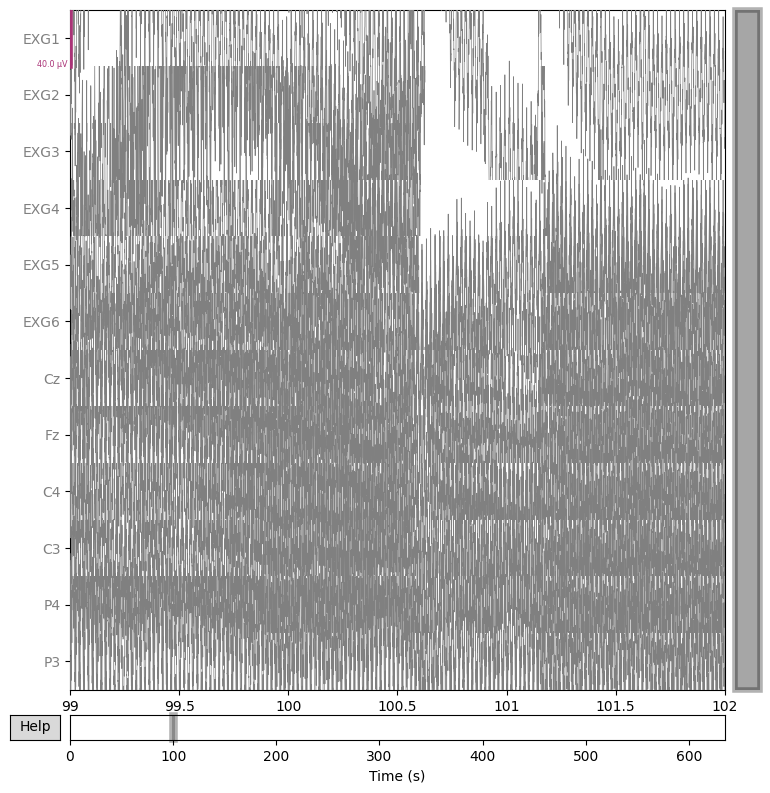

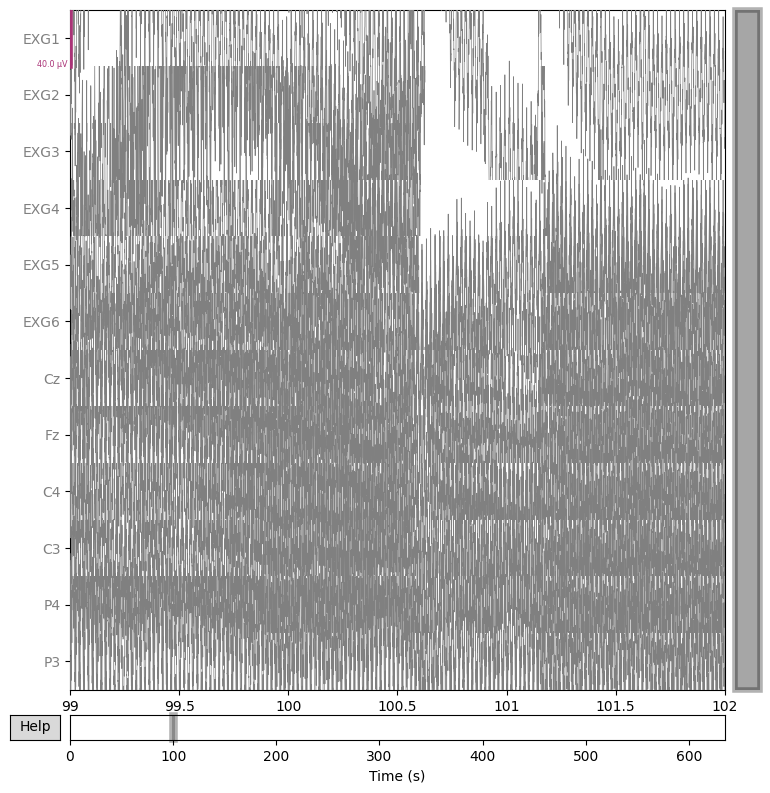

In [6]:
# Define event colors
event_color = {1: "r", 2: "g", 3: "b", 4: "m", 5: "y", 6: "k", 7: "c"}

# Plot the data with events
all_events_arr = np.asarray(all_events)
raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=3,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
    )


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


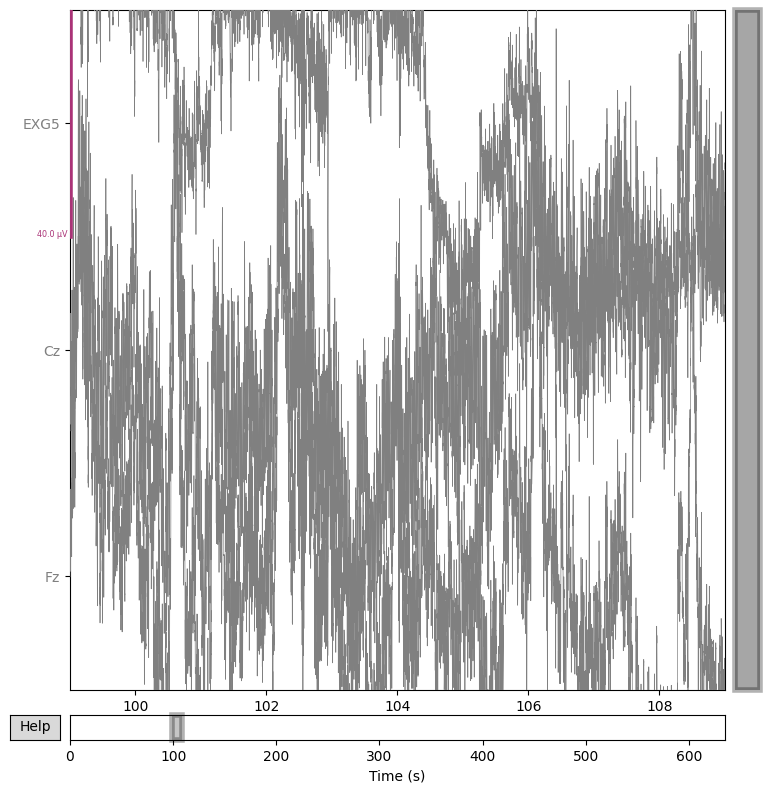

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (1.651 s)



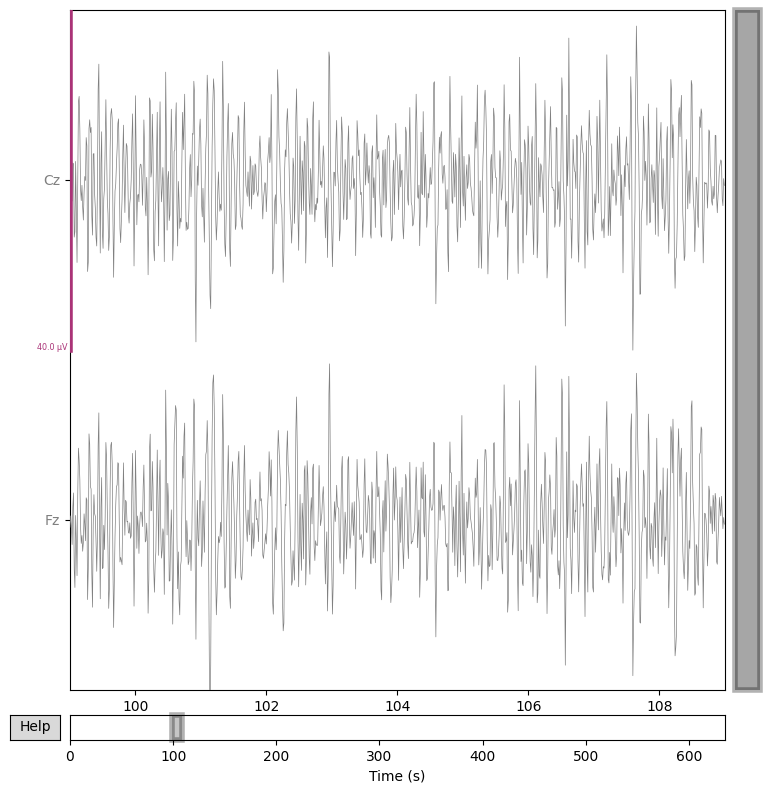

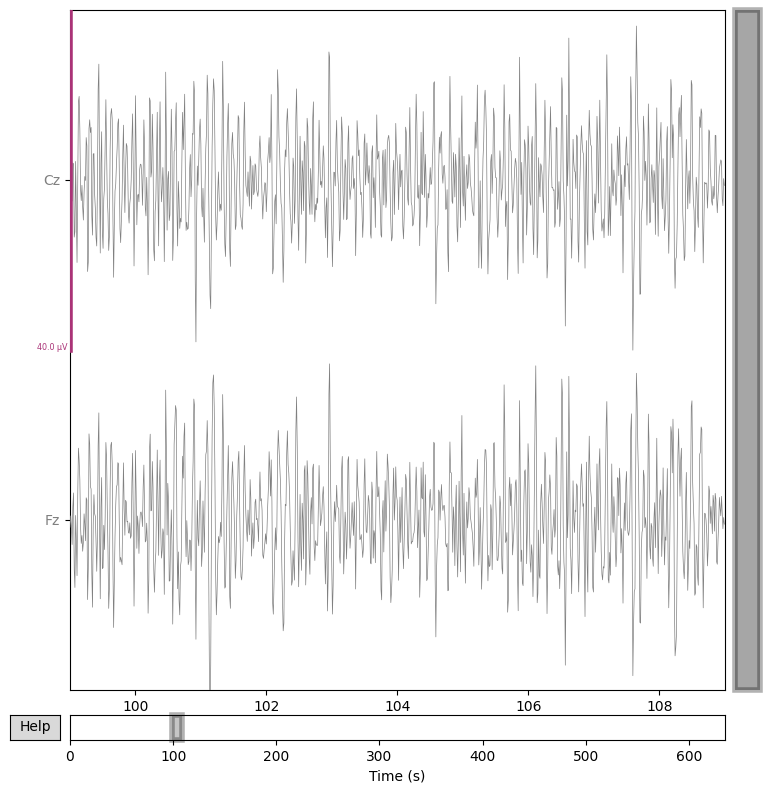

In [7]:
raw_specific_channels.set_eeg_reference(ref_channels=['EXG5','EXG6'])

raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=10,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
        picks=["Cz","Fz","EXG5"]
    )

raw_specific_channels.filter(7.0, 30.0, fir_design="firwin")
raw_specific_channels.plot(
        events=all_events_arr,
        start=99,  # Start time in seconds
        duration=10,  # Duration in seconds to be plotted
        color="gray",
        event_color=event_color,
        picks=["Cz","Fz"]
    )

In [8]:
raw_specific_channels.set_channel_types({'EXG1':'eog','EXG2':'eog','EXG3':'eog','EXG4':'eog'})

# Define a mapping dictionary from original channel names to standard electrode names
channel_mapping = {
    'EXG5':'A1', 
    'EXG6':'A2'
    # Add more mappings as needed
}

# Rename channels in your raw data using the mapping
raw_specific_channels.rename_channels(channel_mapping)

# Define event IDs for epochs of interest
event_id = {'event_1': 2, 'event_2': 4}  # Replace with your actual event IDs

# Define epoch parameters
tmin, tmax = -0.5, 0.2  # Start and end times in seconds

# Create epochs
epochs = mne.Epochs(raw_specific_channels, all_events, event_id, tmin, tmax, preload=True)

# Label epochs based on event ID
labels = epochs.events[:, -1]

Not setting metadata
211 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 211 events and 1435 original time points ...
0 bad epochs dropped


In [9]:
labels

array([4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 2, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2,
       4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4,
       4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4,
       4, 2, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 2])

In [10]:

total_4 = 0
total_2 = 0
for i in labels:
    if(i==2):
        total_2 = total_2+1
    if(i==4):
        total_4 = total_4+1

In [11]:

def split_epochs_stratified_kfold(epochs, n_splits=5, random_state=None):
    data = epochs.get_data(copy=True)
    labels = epochs.events[:, -1]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    splits = []
    
    for train_index, test_index in skf.split(data, labels):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        splits.append((X_train, X_test, y_train, y_test))
    
    return splits

In [12]:


avg_true_pos = []
avg_false_pos = []
avg_true_neg = []
avg_false_neg = []
sum_true_pos = []
sum_true_neg = []
sum_false_pos = []
sum_false_neg = []
# # Select epochs and labels for the events of interest
epochs_data = epochs.get_data(copy=True)

# # Check for NaNs and Infs
# if np.isnan(epochs_data).sum() > 0 or not np.isfinite(epochs_data).all():
#     raise ValueError("Data contains NaNs or infinite values.")
    


# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)
accuracies = []
true_pos = []
false_pos = []
true_neg = []
false_neg = []
splits = split_epochs_stratified_kfold(epochs, n_splits=5, random_state=42)
for X_train, X_test, y_train, y_test in splits:
    print(f"train_data_length = {len(X_train)}")
    print(f"test_data_length = {len(X_test)}")
    # Initialize CSP
    
    csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

    # Create a classification pipeline with CSP and LDA
    clf = Pipeline([('CSP', csp), ('LDA', LDA())])

    # Train the classifier
    clf.fit(X_train, y_train)

    # Test the classifier
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(y_test)
    print(y_pred)
    tp=0
    tn=0
    fp=0 
    fn=0
    for yt,yp in zip(y_test,y_pred):
        if((yt==2)and(yp==2)):
            tp = tp+1
        elif((yt==2)and(yp==4)):
            fn = fn+1
        elif((yt==4)and(yp==4)):
            tn = tn+1
        elif((yt==4)and(yp==2)):
            fp = fp+1
    print(f"tp - {tp}")
    print(f"fn - {fn}")
    print(f"tn - {tn}")
    print(f"fp - {fp}")

    if(tp!=0):
        true_pos.append((tp/(tp+fp))) 
    else:
        true_pos.append(0.0) 
    if(fp!=0):
        false_pos.append((fp/(tp+fp)))  
    else:
        false_pos.append(0.0) 
    if(tn!=0):
        true_neg.append((tn/(tn+fn)))  
    else:
        true_pos.append(0.0) 
    if(fn!=0):
        false_neg.append((fn/(tn+fn))) 
    else:
        true_pos.append(0.0) 
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
average_accuracy = np.mean(accuracies)
average_true_pos = np.mean(true_pos)
average_true_neg = np.mean(true_neg)
average_false_pos = np.mean(false_pos)
average_false_neg = np.mean(false_neg)
print(f"average_accuracy - {average_accuracy}")
avg_true_pos.append(average_true_pos*100)
avg_false_pos.append(average_false_pos*100)
avg_true_neg.append(average_true_neg*100)
avg_false_neg.append(average_false_neg*100)


train_data_length = 168
test_data_length = 43
Computing rank from data with rank=None
    Using tolerance 2.3e-05 (2.2e-16 eps * 12 dim * 8.6e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       0.75      0.75      0.75         8
           4       0.94      0.94      0.94        35

    accuracy                           0.91        43
   macro avg       0.85      0.85      0.85        43
weighted avg       0.91      0.91      0.91        43

[4 4 4 4 4 4 4 4 4 4 2 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 2 2 4 4 2 4 4 2 4 4 2
 4 4 4 2 4 4]
[4 2 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 2 4 4 4 4 4 4 4 4 4 2 4 4 2 4 4 2 4 4 2
 4 4 4 2 4 4]
tp - 6
fn - 2
tn - 33
fp - 2
train_data_length = 169
test_data_length = 42
Computing rank 

In [13]:
avg_false_pos

[30.83333333333333]

In [14]:
average_true_pos

0.6916666666666667

In [15]:
# # Check for NaNs and Infs
# if np.isnan(epochs_data).sum() > 0 or not np.isfinite(epochs_data).all():
#     raise ValueError("Data contains NaNs or infinite values.")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)


Computing rank from data with rank=None
    Using tolerance 2.6e-05 (2.2e-16 eps * 12 dim * 9.6e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.


array([[-2.03254032e+00, -8.09998274e-01, -5.46500637e+01,
        -1.75891871e+00],
       [-2.41309704e+00, -1.11235278e+00, -5.46593112e+01,
        -1.65196904e+00],
       [ 2.21798709e-01,  3.36852249e-01, -5.46758881e+01,
        -1.20575609e+00],
       [-2.06449642e-01, -3.76671074e-02, -5.46004128e+01,
        -1.40136037e+00],
       [-4.44218664e-01, -1.40105845e+00, -5.44617322e+01,
        -1.48949353e+00],
       [-1.76827118e+00, -2.01588321e+00, -5.47316135e+01,
        -1.15730250e+00],
       [-2.12044201e-01,  1.37474529e-01, -5.45633624e+01,
         3.48578662e-01],
       [-2.35810614e-01,  1.21543412e-01, -5.45555441e+01,
         3.25634482e-01],
       [-6.99470324e-01, -3.95423729e-01, -5.49174577e+01,
        -1.16482236e-02],
       [-4.15560015e-01,  4.81253354e-01, -5.46171197e+01,
         9.55118424e-01],
       [-1.81552769e+00,  8.62418970e-02, -5.44797028e+01,
         6.27130039e-01],
       [-7.89211287e-02, -5.07066712e-01, -5.46927700e+01,
      

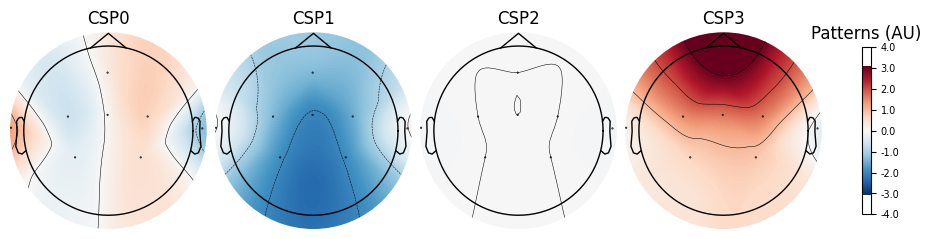

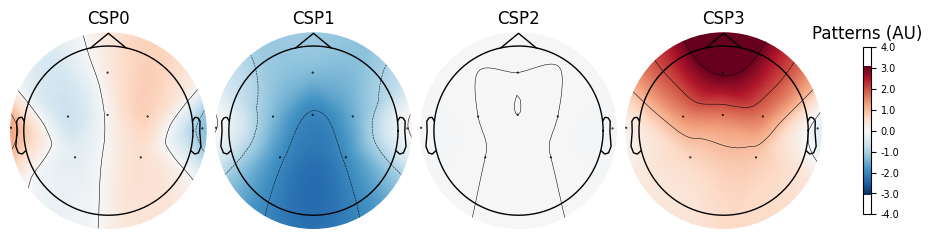

In [16]:


montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [17]:
print(raw_specific_channels.info)


<Info | 9 non-empty values
 bads: []
 ch_names: EXG1, EXG2, EXG3, EXG4, A1, A2, Cz, Fz, C4, C3, P4, P3
 chs: 4 EOG, 8 EEG
 custom_ref_applied: True
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2024-07-04 15:30:06 UTC
 nchan: 12
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 1 item (dict)
>


In [18]:
# all_threshold = [0.0]
# def conv_sample_to_time(sample_id):
#     return sample_id/2048.0 
# for m in range(1,11):
#     ignore_events_threshold = m*0.2
#     all_threshold.append(ignore_events_threshold)
# # ignore_events_threshold = 1.5
#     popped_box_events = []
#     cleaned_box_events = []
#     trial = 0;
#     previous_index_2 = 0
#     previous_index_4 = 0
#     # Iterate through the data and track instances when the value changes
#     for [i,x, value] in all_events:
#         if value==1:
#             cleaned_box_events.append([i,x, value])
#             trial+=1
#         elif value==7:
#             cleaned_box_events.append([i,x, value])
#         elif value==2:
#             cleaned_box_events.append([i,x, value])
#             previous_index_2 = i
#         elif value==4:
#             cleaned_box_events.append([i,x, value])
#             previous_index_4 = i
#         elif value==5:
#             prev_time = conv_sample_to_time(previous_index)
#             curr_time = conv_sample_to_time(i)
#             time_diff = curr_time - prev_time
#             if previous_value==4 and time_diff<ignore_events_threshold:
#                 temp = cleaned_box_events.pop()
#                 popped_box_events.append(temp)
#         elif value==3:
#             prev_time = conv_sample_to_time(previous_index_2)
#             curr_time = conv_sample_to_time(i)
#             time_diff = curr_time - prev_time
#             if time_diff<ignore_events_threshold:
#                 temp = cleaned_box_events.pop()
#                 popped_box_events.append(temp)
#         elif value==6:
#             prev_time = conv_sample_to_time(previous_index_2)
#             curr_time = conv_sample_to_time(i)
#             time_diff = curr_time - prev_time
#             if time_diff<ignore_events_threshold:
#                 temp = cleaned_box_events.pop()
#                 popped_box_events.append(temp)
        

#         previous_value = value
#         previous_index = i

#     print(cleaned_box_events)

#     # Create epochs
#     epochs = mne.Epochs(raw_specific_channels, cleaned_box_events, event_id, tmin, tmax, preload=True)
#     # Create epochs using popped data
#     popped_box_events_np = np.array(popped_box_events)
#     present_event_ids = {key: val for key, val in event_id.items() if val in popped_box_events_np[:, 2]}
#     epochs_2 = mne.Epochs(raw_specific_channels, popped_box_events, present_event_ids, tmin, tmax, preload=True)
    
#     data2 = epochs.get_data(copy=True)
#     labels2 = epochs.events[:, -1]
#     # Label epochs based on event ID
#     labels = epochs.events[:, -1]


#     #count false_neg and true_neg from omitted by threshold
#     cur_4 = 0
#     cur_2 = 0
#     for i in labels:
#         if(i==2):
#             cur_2 = cur_2+1
#         if(i==4):
#             cur_4 = cur_4+1

#     buf_fn = total_2 - cur_2
#     buf_tn = total_4 - cur_4

#     accuracies =[]
#     true_pos = []
#     false_pos = []
#     true_neg = [buf_tn]
#     false_neg = [buf_fn]


#     splits = split_epochs_stratified_kfold(epochs, n_splits=5, random_state=42)
#     for X_train, X_test, y_train, y_test in splits:
#         print(f"train_data_length = {len(X_train)}")
#         print(f"test_data_length = {len(X_test)}")
#         # Initialize CSP

#         csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

#         # Create a classification pipeline with CSP and LDA
#         clf = Pipeline([('CSP', csp), ('LDA', LDA())])
#         # Combine the original training data with the new training data
#         X_train_combined = np.concatenate((X_train, data2), axis=0)
#         y_train_combined = np.concatenate((y_train, labels2), axis=0)
#         # Train the classifier
#         clf.fit(X_train_combined, y_train_combined)

#         # Test the classifier
#         y_pred = clf.predict(X_test)
#         print(classification_report(y_test, y_pred))
#         print(y_test)
#         print(y_pred)
#         tp=0
#         tn=0
#         fp=0 
#         fn=0
#         for yt,yp in zip(y_test,y_pred):
#             if((yt==2)and(yp==2)):
#                 tp = tp+1
#             elif((yt==2)and(yp==4)):
#                 fn = fn+1
#             elif((yt==4)and(yp==4)):
#                 tn = tn+1
#             elif((yt==4)and(yp==2)):
#                 fp = fp+1
#         print(f"tp - {tp}")
#         print(f"fn - {fn}")
#         print(f"tn - {tn}")
#         print(f"fp - {fp}")

#         true_pos.append(tp) 
#         false_pos.append(fp)  
#         true_neg.append(tn)  
#         false_neg.append(fn) 



#         accuracy = accuracy_score(y_test, y_pred)
#         accuracies.append(accuracy)

#     average_accuracy = np.mean(accuracies)
    
#     average_true_pos = np.sum(true_pos)/(np.sum(true_pos)+np.sum(false_pos))
#     average_true_neg = np.sum(true_neg)/(np.sum(true_neg)+np.sum(false_neg))
#     average_false_pos = np.sum(false_pos)/(np.sum(true_pos)+np.sum(false_pos))
#     average_false_neg = np.sum(false_neg)/(np.sum(true_neg)+np.sum(false_neg))
#     print(f"average_accuracy - {average_accuracy}")
#     avg_true_pos.append(average_true_pos*100)
#     avg_false_pos.append(average_false_pos*100)
#     avg_true_neg.append(average_true_neg*100)
#     avg_false_neg.append(average_false_neg*100)




In [26]:


all_threshold = [0.0]
def conv_sample_to_time(sample_id):
    return sample_id/2048.0 
for m in range(1,11):
    ignore_events_threshold = m*0.2
    all_threshold.append(ignore_events_threshold)
    if(ignore_events_threshold>0.5):
        tmax = 0.5
    else:
        tmax = ignore_events_threshold
    accuracies =[]
    true_pos = []
    false_pos = []
    true_neg = []
    false_neg = []
    
    event_4_2 = []
    
    for [i,x, value] in all_events:
        if(value==2 or value==4):
            event_4_2.append([i,x, value])
    event_4_2_np = np.array(event_4_2)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Initialize lists to hold train and test events for each fold
    folds = []
    labels = event_4_2_np[:, 2]
    event_indices = np.arange(len(event_4_2_np))

    # Loop over the cross-validation splits
    for train_index, test_index in skf.split(event_4_2_np,labels):
        train_events = event_4_2_np[train_index]
        test_events = event_4_2_np[test_index]
        folds.append((train_events, test_events))

    # Print the events for each fold
    for i, (train_events, test_events) in enumerate(folds):
        print(f'Fold {i+1}')
#         print('Train Events:', train_events)
#         print('Test Events:', test_events)
#         print()

        # training Create epochs
        training_epochs = mne.Epochs(raw_specific_channels, train_events, event_id, tmin, tmax, preload=True)
        X_train = training_epochs.get_data(copy=True)
        y_train = training_epochs.events[:, -1]
        
        popped_box_events = []
        cleaned_box_events = []
        remove_train_events = []
        
        train_events_list = train_events.tolist()
        # Filter events to remove specific matches
        for ev in all_events:
            if ev not in train_events_list:
                remove_train_events.append(ev)
        

        
        

        trial = 0;
        previous_index_2 = 0
        previous_index_4 = 0
        # Iterate through the data and track instances when the value changes
        for [i,x, value] in remove_train_events:
            if value==1:
                cleaned_box_events.append([i,x, value])
                trial+=1
            elif value==7:
                cleaned_box_events.append([i,x, value])
            elif value==2:
                cleaned_box_events.append([i,x, value])
                previous_index_2 = i
            elif value==4:
                cleaned_box_events.append([i,x, value])
                previous_index_4 = i
            elif value==5:
                prev_time = conv_sample_to_time(previous_index)
                curr_time = conv_sample_to_time(i)
                time_diff = curr_time - prev_time
                if previous_value==4 and time_diff<ignore_events_threshold:
                    temp = cleaned_box_events.pop()
                    popped_box_events.append(temp)
            elif value==3:
                prev_time = conv_sample_to_time(previous_index_2)
                curr_time = conv_sample_to_time(i)
                time_diff = curr_time - prev_time
                if time_diff<ignore_events_threshold:
                    temp = cleaned_box_events.pop()
                    popped_box_events.append(temp)
            elif value==6:
                prev_time = conv_sample_to_time(previous_index_2)
                curr_time = conv_sample_to_time(i)
                time_diff = curr_time - prev_time
                if time_diff<ignore_events_threshold:
                    temp = cleaned_box_events.pop()
                    popped_box_events.append(temp)
        

            previous_value = value
            previous_index = i
#         print("popped_box_events")
#         print(popped_box_events)
        
        cleaned_box_events_np = np.array(cleaned_box_events)
        present_event_ids = {key: val for key, val in event_id.items() if val in cleaned_box_events_np[:, 2]}
        # Create test  epochs
        test_epochs = mne.Epochs(raw_specific_channels, cleaned_box_events, present_event_ids, tmin, tmax, preload=True)
        X_test = test_epochs.get_data(copy=True)
        y_test = test_epochs.events[:, -1]
        csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)

        # Create a classification pipeline with CSP and LDA
        clf = Pipeline([('CSP', csp), ('LDA', LDA())])        
        # Train the classifier
        clf.fit(X_train, y_train)

        # Test the classifier
        y_pred = clf.predict(X_test)        
        
        print(classification_report(y_test, y_pred))
        print(y_test)
        print(y_pred)    
        
        #count false_neg and true_neg from omitted by threshold
        cur_4 = 0
        cur_2 = 0
        for [i,x, value] in popped_box_events:
            if(value==2):
                cur_2 = cur_2+1
            if(value==4):
                cur_4 = cur_4+1
        tp=0
        tn=cur_4
        fp=0 
        fn=cur_2
        for yt,yp in zip(y_test,y_pred):
            if((yt==2)and(yp==2)):
                tp = tp+1
            elif((yt==2)and(yp==4)):
                fn = fn+1
            elif((yt==4)and(yp==4)):
                tn = tn+1
            elif((yt==4)and(yp==2)):
                fp = fp+1    

        print(f"tp - {tp}")
        print(f"fn - {fn}")
        print(f"tn - {tn}")
        print(f"fp - {fp}")

        true_pos.append(tp) 
        false_pos.append(fp)  
        true_neg.append(tn)  
        false_neg.append(fn) 



        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    
    average_true_pos = np.sum(true_pos)/(np.sum(true_pos)+np.sum(false_pos))
    average_true_neg = np.sum(true_neg)/(np.sum(true_neg)+np.sum(false_neg))
    average_false_pos = np.sum(false_pos)/(np.sum(true_pos)+np.sum(false_pos))
    average_false_neg = np.sum(false_neg)/(np.sum(true_neg)+np.sum(false_neg))
    print(f"average_accuracy - {average_accuracy}")
    avg_true_pos.append(average_true_pos*100)
    avg_false_pos.append(average_false_pos*100)
    avg_true_neg.append(average_true_neg*100)
    avg_false_neg.append(average_false_neg*100)




Fold 1
Not setting metadata
168 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 168 events and 1435 original time points ...
0 bad epochs dropped
Not setting metadata
22 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 1435 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.3e-05 (2.2e-16 eps * 12 dim * 8.6e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6
     

0 projection items activated
Using data from preloaded Raw for 169 events and 1844 original time points ...
0 bad epochs dropped
Not setting metadata
11 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11 events and 1844 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.6e-05 (2.2e-16 eps * 12 dim * 9.6e+09  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.60      0.75         5
           4       0.75      1.00      0.86         6

    accuracy                           0.82        11
   macro avg       0.88      0.80  

    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.71      0.83         7
           4       0.00      0.00      0.00         0

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7

[2 2 2 2 2 2 2]
[2 2 2 2 4 4 2]
tp - 5
fn - 3
tn - 34
fp - 0
Fold 4
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
8 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline 

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.67      0.80         6
           4       0.50      1.00      0.67         2

    accuracy                           0.75         8
   macro avg       0.75      0.83      0.73         8
weighted avg       0.88      0.75      0.77         8

[4 2 2 2 2 4 2 2]
[4 2 2 4 4 4 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
12

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         0

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

[2 2 2 2 2 2]
[2 2 4 4 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
9 matching

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.75      0.86         8
           4       0.33      1.00      0.50         1

    accuracy                           0.78         9
   macro avg       0.67      0.88      0.68         9
weighted avg       0.93      0.78      0.82         9

[4 2 2 2 2 2 2 2 2]
[4 2 2 2 2 2 4 4 2]
tp - 6
fn - 2
tn - 34
fp - 0
average_accuracy - 0.7746031746031746
Fold 1
Not setting metadata
168 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 168 events and 2049 original time points ...
0 

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         0

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

[2 2 2 2 2 2]
[2 2 4 4 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
9 matching

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.75      0.86         8
           4       0.33      1.00      0.50         1

    accuracy                           0.78         9
   macro avg       0.67      0.88      0.68         9
weighted avg       0.93      0.78      0.82         9

[4 2 2 2 2 2 2 2 2]
[4 2 2 2 2 2 4 4 2]
tp - 6
fn - 2
tn - 34
fp - 0
average_accuracy - 0.765079365079365
Fold 1
Not setting metadata
168 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 168 events and 2049 original time points ...
0 b

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         0

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

[2 2 2 2 2 2]
[2 2 4 4 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
8 matching

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.75      0.86         8
           4       0.00      0.00      0.00         0

    accuracy                           0.75         8
   macro avg       0.50      0.38      0.43         8
weighted avg       1.00      0.75      0.86         8

[2 2 2 2 2 2 2 2]
[2 2 2 2 2 4 4 2]
tp - 6
fn - 2
tn - 34
fp - 0
average_accuracy - 0.7595238095238095
Fold 1
Not setting metadata
168 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 168 events and 2049 original time points ...
0 bad 

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[2 2 2 2 2 2]
[2 2 2 2 2 2]
tp - 6
fn - 2
tn - 35
fp - 0
Fold 2
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
5 matching events found
Setting baseline interval to [-0.5, 0.0]

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.71      0.83         7
           4       0.00      0.00      0.00         0

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7

[2 2 2 2 2 2 2]
[2 2 2 2 4 4 2]
tp - 5
fn - 3
tn - 34
fp - 0
Fold 4
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
6 matc

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         0

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

[2 2 2 2 2 2]
[2 2 4 4 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
8 matching

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.75      0.86         8
           4       0.00      0.00      0.00         0

    accuracy                           0.75         8
   macro avg       0.50      0.38      0.43         8
weighted avg       1.00      0.75      0.86         8

[2 2 2 2 2 2 2 2]
[2 2 2 2 2 4 4 2]
tp - 6
fn - 2
tn - 34
fp - 0
average_accuracy - 0.7461904761904762
Fold 1
Not setting metadata
168 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 168 events and 2049 original time points ...
0 bad 

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[2 2 2 2 2 2]
[2 2 2 2 2 2]
tp - 6
fn - 2
tn - 35
fp - 0
Fold 2
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
4 matching events found
Setting baseline interval to [-0.5, 0.0]

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.71      0.83         7
           4       0.00      0.00      0.00         0

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7

[2 2 2 2 2 2 2]
[2 2 2 2 4 4 2]
tp - 5
fn - 3
tn - 34
fp - 0
Fold 4
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
6 matc

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         0

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

[2 2 2 2 2 2]
[2 2 4 4 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
8 matching

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.75      0.86         8
           4       0.00      0.00      0.00         0

    accuracy                           0.75         8
   macro avg       0.50      0.38      0.43         8
weighted avg       1.00      0.75      0.86         8

[2 2 2 2 2 2 2 2]
[2 2 2 2 2 4 4 2]
tp - 6
fn - 2
tn - 34
fp - 0
average_accuracy - 0.7261904761904762
Fold 1
Not setting metadata
168 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 168 events and 2049 original time points ...
0 bad 

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[2 2 2 2 2 2]
[2 2 2 2 2 2]
tp - 6
fn - 2
tn - 35
fp - 0
Fold 2
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
4 matching events found
Setting baseline interval to [-0.5, 0.0]

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.71      0.83         7
           4       0.00      0.00      0.00         0

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7

[2 2 2 2 2 2 2]
[2 2 2 2 4 4 2]
tp - 5
fn - 3
tn - 34
fp - 0
Fold 4
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
5 matc

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.80      0.89         5
           4       0.00      0.00      0.00         0

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5

[2 2 2 2 2]
[2 2 4 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
7 matching eve

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.71      0.83         7
           4       0.00      0.00      0.00         0

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7

[2 2 2 2 2 2 2]
[2 2 2 2 4 4 2]
tp - 5
fn - 3
tn - 34
fp - 0
average_accuracy - 0.7457142857142858
Fold 1
Not setting metadata
168 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 168 events and 2049 original time points ...
0 bad epoc

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[2 2 2 2 2 2]
[2 2 2 2 2 2]
tp - 6
fn - 2
tn - 35
fp - 0
Fold 2
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
4 matching events found
Setting baseline interval to [-0.5, 0.0]

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         0

    accuracy                           0.67         6
   macro avg       0.50      0.33      0.40         6
weighted avg       1.00      0.67      0.80         6

[2 2 2 2 2 2]
[2 2 2 4 4 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 4
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
4 matching

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

    Using tolerance 2.7e-05 (2.2e-16 eps * 12 dim * 1e+10  max singular value)
    Estimated rank (data): 12
    data: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=4 covariance using LEDOIT_WOLF
Done.
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

[2 2 2 2]
[2 2 2 2]
tp - 4
fn - 4
tn - 34
fp - 0
Fold 5
Not setting metadata
169 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 169 events and 2049 original time points ...
0 bad epochs dropped
Not setting metadata
7 matching events found
Setting baseline interval to [-0.5, 0.0] s
Apply

/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/reniflalebenezer/opt/anaconda3/envs/psychopy_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [27]:
popped_box_events_np = np.array(popped_box_events)

present_event_ids = {key: val for key, val in event_id.items() if val in popped_box_events_np[:, 2]}


In [29]:
all_threshold

[0.0,
 0.2,
 0.4,
 0.6000000000000001,
 0.8,
 1.0,
 1.2000000000000002,
 1.4000000000000001,
 1.6,
 1.8,
 2.0]

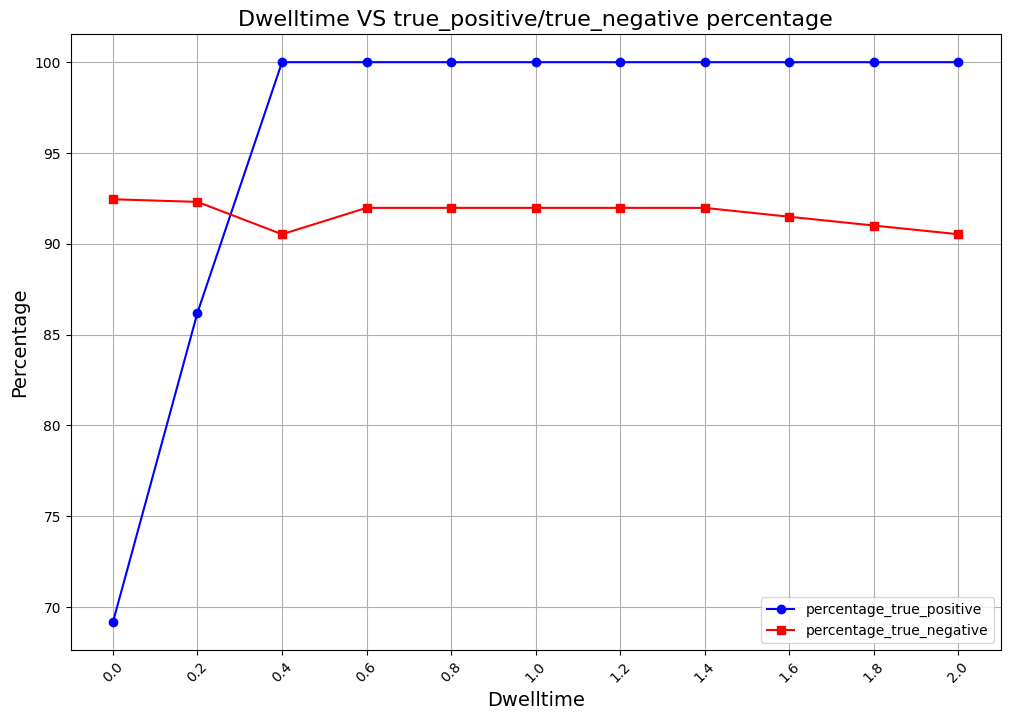

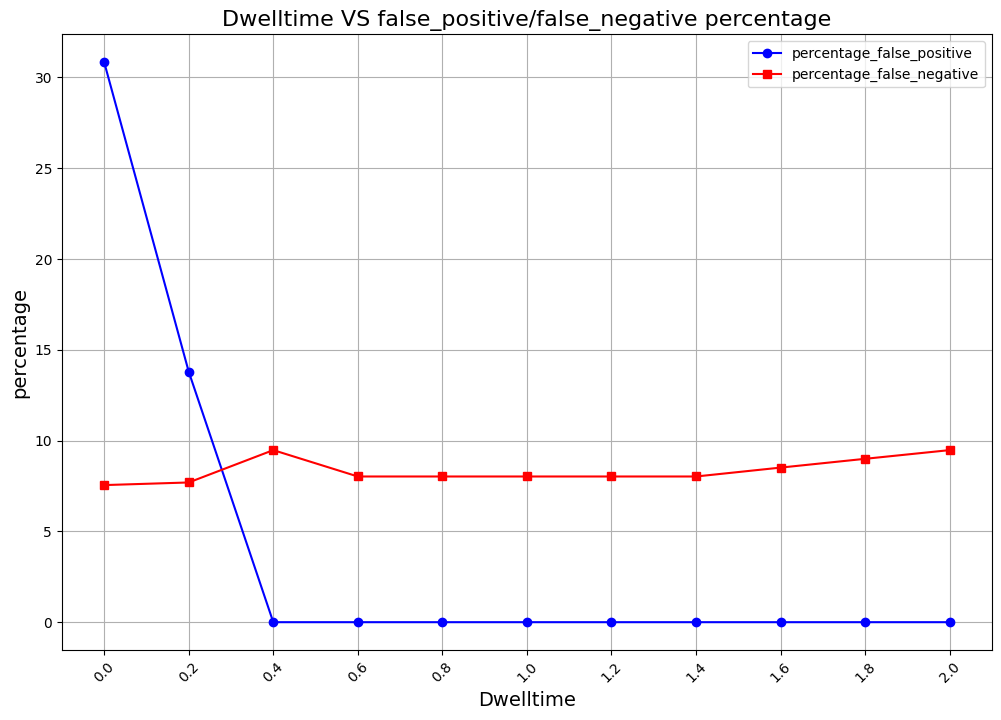

In [30]:
data_for_graph = {
    "Dwelltime":[],
    "count_true_positive":[],
    "count_false_positive":[],
    "count_true_negative":[],
    "count_false_negative":[]
    
}
for m in range(0,11):
    ignore_events_threshold = m*0.2
    data_for_graph["Dwelltime"].append(str(round(ignore_events_threshold,2)))
data_for_graph["count_true_positive"] = avg_true_pos
data_for_graph["count_false_positive"]= avg_false_pos
data_for_graph["count_true_negative"] = avg_true_neg
data_for_graph["count_false_negative"] = avg_false_neg

# Plotting the line chart
plt.figure(figsize=(12, 8))
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_true_positive"], marker='o', linestyle='-', color='b', label='percentage_true_positive')
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_true_negative"], marker='s', linestyle='-', color='r', label='percentage_true_negative')

# Adding titles and labels
plt.title('Dwelltime VS true_positive/true_negative percentage', fontsize=16)
plt.xlabel('Dwelltime', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Displaying the chart
plt.show()

# Plotting the line chart
plt.figure(figsize=(12, 8))
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_false_positive"], marker='o', linestyle='-', color='b', label='percentage_false_positive')
plt.plot(data_for_graph["Dwelltime"], data_for_graph["count_false_negative"], marker='s', linestyle='-', color='r', label='percentage_false_negative')

# Adding titles and labels
plt.title('Dwelltime VS false_positive/false_negative percentage', fontsize=16)
plt.xlabel('Dwelltime', fontsize=14)
plt.ylabel('percentage', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Displaying the chart
plt.show()

In [23]:
# print(len(channel_trigger))
# # Plotting the line chart
# plt.figure(figsize=(12, 8))
# plt.plot(channel_trigger[775936:785936], marker='s', linestyle='-', color='r', label='count_true_negative')

# # Adding titles and labels
# plt.title('Dwelltime VS count_true_positive/count_true_negative percentage', fontsize=16)
# plt.xlabel('Dwelltime', fontsize=14)
# plt.ylabel('Percentage', fontsize=14)
# plt.xticks(rotation=45)
# plt.legend()
# plt.grid(True)

# # Displaying the chart
# plt.show()

In [ ]:
# Specify the file name
file_name = 'eeg_data_for_graph.json'

# Save the dictionary to a file
with open(file_name, 'w') as file:
    json.dump(data_for_graph, file)
    
# Save the dictionary to a file
with open(graph_file, 'w') as file:
    json.dump(data_for_graph, file)